In [103]:
%%capture
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import statnlpbook.util as util
import statnlpbook.parsing as parsing
util.execute_notebook('parsing.ipynb')

<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\a}{\alpha}
\newcommand{\b}{\beta}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

# Parsing

##  Motivation 

Say want to automatically build a database of this form

| Brand   | Parent    |
|---------|-----------|
| KitKat  | Nestle    |
| Lipton  | Unilever  |  
| ...     | ...       |  

or this [graph](http://geekologie.com/image.php?path=/2012/04/25/parent-companies-large.jpg)

Say you find positive textual mentions in this form:

> <font color="blue">Dechra Pharmaceuticals</font> has made its second acquisition after purchasing <font color="green">Genitrix</font>.


> <font color="blue">Trinity Mirror plc</font> is the largest British newspaper after purchasing rival <font color="green">Local World</font>.

Can you find a pattern? 

How about this sentence 

> <font color="blue">Kraft</font> is gearing up for a roll-out of its <font color="blue">Milka</font> brand after purchasing  <font color="green">Cadbury Dairy Milk</font>.


Wouldn't it be great if we knew that

* Kraft is the **subject** of the phrase **purchasing Cadbury Dairy Milk** 

Check out [enju parser](http://www.nactem.ac.uk/enju/demo.html#2)

Parsing is is the process of **finding these trees**:

* very important for downstream applications
* the "celebrity" sub-field of NLP 
    * partly because it  marries linguistics and NLP
* researched bigly in academia and [industry](http://www.telegraph.co.uk/technology/2016/05/17/has-googles-parsey-mcparseface-just-solved-one-of-the-worlds-big/)

How is this done?

## Syntax
from the Greek syntaxis (arrangement):

* **Constituency**: groups of words act as single units.
* **Grammatical Relations**: object, subject, direct object etc. 
* **Subcategorization**: restrictions on the type of phrases that go with certain words.


### Constituency

* **Noun Phrase** (NP)
    * a roll-out of its Milka brand
    * Cadbury Dairy Milk
    * a roll-out
* **Verb Phrase** (VP) 
    * is gearing up
    * purchasing Cadbury Dairy Milk 
* **Prepositional Phrase** (PP)
    * of its Milka brand
    * after purchasing Cadbury Dairy Milk

### Grammatical Relations
> <font color="blue">Kraft</font> is gearing up for a roll-out of its <font color="blue">Milka</font> brand after purchasing  <font color="green">Cadbury Dairy Milk</font>.

* *Subject* of purchasing: **Kraft**
* *Object* of purchasing: **Cadbury Dairy Milk**

### Subcategorization

There are more complex (sub) categories of verbs (and other types of words)

* Intransitive Verbs: must not have objects
    * the student works
* Transitive Verbs: must have exactly one object
    * Kraft purchased Cadbury Dairy Milk
* Ditransitive Verbs: must have two objects
    * Give me a break! 


## Context Free Grammars 

Formalise syntax by describing the hierarchical structure of sentences


A **Context Free Grammar** (CFG) is a 4-tuple \\(G=(N,\Sigma,R,S)\\) where

  * \\(N\\) is a set of _non-terminal symbols_.
  * \\(\Sigma\\) is a set of _terminal symbols_.
  * \\(R\\) is a finite set of _rules_ \\(X \rightarrow Y_1 Y_2\ldots Y_n\\) where \\(X \in N\\) and \\(Y_i \in N \cup \Sigma\\). 
  * \\(S \in N\\) is a _start symbol_. 


Simple example grammar:
* NP_p : plural Noun Phrase
* NP_s : singular Noun Phrase
* VP_s/p: same for verb phrases

In [104]:
cfg = CFG.from_rules([('S',    ['NP_p','VP_p']),('S',['NP_s','VP_s']), 
                      ('NP_p', ['Matko', 'raps']),
                      ('VP_p', ['are', 'ADJ']),
                      ('NP_s', ['Matko']),
                      ('VP_s', ['raps', 'in', 'StatNLP']),
                      ('ADJ',  ['silly'])
                     ])
cfg

S,NP_p VP_p
S,NP_s VP_s
NP_p,Matko raps
VP_p,are ADJ
NP_s,Matko
VP_s,raps in StatNLP
ADJ,silly


## (Left-most) Derivation
The structure of a sentence with respect to a grammar can be described by its **derivation** (if it exists) 

Sequence of sequences \\(s_1 \ldots s_n\\) such that 

* \\(s_1 = S\\)
    * first sequence is the start symbol
* \\(s_n \in \Sigma^*\\)
    * last sequence consists of only terminals.
* \\(s_i\\) for \\(i > 1\\)
    * replace left-most non-terminal \\(\alpha\\) in $s_{i-1}$ with right-hand of $\alpha\rightarrow \beta_1,\ldots,\beta_n$

In [105]:
generate_deriv(cfg, [cfg.s])

(['S'],
 ['NP_p', 'VP_p'],
 ['Matko', 'raps', 'VP_p'],
 ['Matko', 'raps', 'are', 'ADJ'],
 ['Matko', 'raps', 'are', 'silly'])

## Parse Trees
Represent derivations as trees

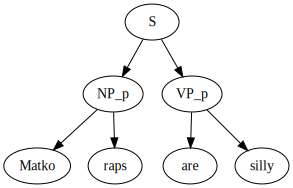

In [106]:
tree = ('S', [('NP_p',['Matko','raps']), ('VP_p',['are','silly'])])
parsing.render_tree(tree)

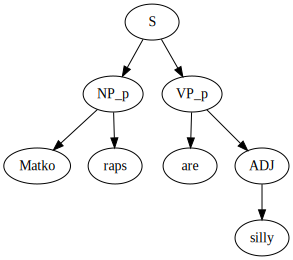

In [107]:
parsing.render_tree(generate_tree(cfg,'S'))        

## Parsing
The inverse problem: given a sentence 

> Matko raps in StatNLP

What's the derivation for it?  

There are a couple of approaches to find a legal parse tree given a sentence and grammar:

* **Top-Down**: Start with the start symbol and generate trees
    * backtrack if they do not match observed sentence
* **Bottom-Up**: Start with the sentence, find rules that generate parts of it
    * backtrack if you can't reach the start symbol
* **Dynamic Programming**: Explore several trees in parallel and re-use computations

### Bottom-Up Parsing with Backtracking

Incrementally build up a tree **left-to-right**, and maintain ...

a **buffer** of remaining words

In [108]:
parsing.render_transitions(transitions[0:1])

Matko raps are silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3",Init


a **stack** of trees build so far

In [109]:
parsing.render_transitions(transitions[-1:])

,Reduce


Perform three types of **actions**:

### Shift
Put first word from buffer to stack (as singleton tree)

In [110]:
parsing.render_transitions(transitions[0:2])

Matko raps are silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3",Init
raps are silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko",Shift


### Reduce
For rule $X \rightarrow Y \: Z$ and stack $Y \: Z$, create new tree headed with $X$

In [111]:
parsing.render_transitions(transitions[11:13])

are silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko <!-- 1 --> 1 raps",Shift
are silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko <!-- 1 --> 1 raps <!-- 2 --> 2 NP_p <!-- 2->0 --> 2->0 <!-- 2->1 --> 2->1",Reduce


### Backtrack
If no rule can be found and the buffer is non-empty, go back to last decision point

In [112]:
parsing.render_transitions(transitions[9:12])

,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko <!-- 1 --> 1 NP_s <!-- 1->0 --> 1->0 <!-- 2 --> 2 raps <!-- 3 --> 3 are <!-- 4 --> 4 silly",Backtrack
raps are silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko",Backtrack
are silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko <!-- 1 --> 1 raps",Shift


### Example

In [113]:
sentence = ['Matko', 'raps', 'are', 'silly']
transitions = bottom_up_parse(cfg, sentence)
cfg

S,NP_p VP_p
S,NP_s VP_s
NP_p,Matko raps
VP_p,are ADJ
NP_s,Matko
VP_s,raps in StatNLP
ADJ,silly


In [114]:
parsing.render_transitions(transitions[:4])

Matko raps are silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3",Init
raps are silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko",Shift
raps are silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko <!-- 1 --> 1 NP_s <!-- 1->0 --> 1->0",Reduce
are silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko <!-- 1 --> 1 NP_s <!-- 1->0 --> 1->0 <!-- 2 --> 2 raps",Shift


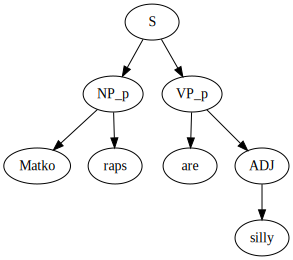

In [115]:
parsing.render_forest(transitions[-1][0].stack)

## Dynamic Programming for Parsing
Bottom-up parser repeats the same work several times

In [116]:
parsing.render_transitions(transitions[7:8]) 

,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko <!-- 1 --> 1 NP_s <!-- 1->0 --> 1->0 <!-- 2 --> 2 raps <!-- 3 --> 3 are <!-- 4 --> 4 silly <!-- 5 --> 5 ADJ <!-- 5->4 --> 5->4 <!-- 6 --> 6 VP_p <!-- 6->3 --> 6->3 <!-- 6->5 --> 6->5",Reduce


In [117]:
parsing.render_transitions(transitions[10:13])

raps are silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko",Backtrack
are silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko <!-- 1 --> 1 raps",Shift
are silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko <!-- 1 --> 1 raps <!-- 2 --> 2 NP_p <!-- 2->0 --> 2->0 <!-- 2->1 --> 2->1",Reduce


In [118]:
parsing.render_transitions(transitions[-2:-1])

,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko <!-- 1 --> 1 raps <!-- 2 --> 2 NP_p <!-- 2->0 --> 2->0 <!-- 2->1 --> 2->1 <!-- 3 --> 3 are <!-- 4 --> 4 silly <!-- 5 --> 5 ADJ <!-- 5->4 --> 5->4 <!-- 6 --> 6 VP_p <!-- 6->3 --> 6->3 <!-- 6->5 --> 6->5",Reduce


Fortunately we can **cache** these computations

### Chomsky Normal Form
Algorithm for caching requires **Chomsky Normal Form**

Rules have form:

* \\(\alpha \rightarrow \beta \gamma\\) where \\(\beta,\gamma \in N \setminus \\{ S  \\} \\). 
    * rule with exactly two non-terminals on RHS
* \\(\alpha \rightarrow t\\) where \\(t \in \Sigma\\)
    * rule that expands to single non-terminal

## Conversion to CNF
We can convert every CFG into an equivalent CFG in CNF

Replace left rules by right rules:  

* $\alpha \rightarrow \beta \gamma \delta \Rightarrow \alpha \rightarrow \beta\alpha', \alpha' \rightarrow \gamma \delta$
* $\alpha \rightarrow \beta t \Rightarrow \alpha \rightarrow \beta \alpha', \alpha' \rightarrow t$ where $t \in \Sigma$
* $\alpha \rightarrow \beta, \beta \rightarrow \gamma \delta \Rightarrow \alpha \rightarrow \gamma \delta, \beta \rightarrow \gamma \delta$ 


## Example

$S \rightarrow NP \: VP \: PP$ 

becomes $S \rightarrow S' \: PP$ and $S' \rightarrow NP \: VP$

$VP \rightarrow \text{are} \: ADJ$ 

becomes $VP \rightarrow X \: ADJ$ and $X \rightarrow \text{are}$

In [119]:
cnf_cfg = to_cnf(cfg)
cnf_cfg

S,NP_p VP_p
S,NP_s VP_s
NP_p_0,Matko
NP_p_1,raps
NP_p,NP_p_0 NP_p_1
VP_p_2,are
VP_p,VP_p_2 ADJ
NP_s,Matko
VP_s_4,raps
VP_s,VP_s_4 VP_s_3
VP_s_3_5,in


### Cocke–Younger–Kasami (CYK) Algorithm

**Incrementally** build all parse trees for **spans of increasing length**

Like the one for "are silly" and "Matko Raps":

In [120]:
parsing.render_transitions(transitions[16:17]) 

,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko <!-- 1 --> 1 raps <!-- 2 --> 2 NP_p <!-- 2->0 --> 2->0 <!-- 2->1 --> 2->1 <!-- 3 --> 3 are <!-- 4 --> 4 silly <!-- 5 --> 5 ADJ <!-- 5->4 --> 5->4 <!-- 6 --> 6 VP_p <!-- 6->3 --> 6->3 <!-- 6->5 --> 6->5",Reduce


Requires a **chart** to store 
* legal non-terminals per span 
* and back-pointers to child spans

In [121]:
chart = parsing.Chart(sentence)
chart.append_label(0,0,'NP_s')
chart.append_label(0,0,'NP_p_0')
chart.append_label(1,1,'VP_s_6')
chart.append_label(1,1,'NP_p_1')
chart.append_label(0,1,'NP_p_2', [(0,0,'NP_p_0'),(1,1,'NP_p_1')]) 
chart.mark(0, 1, 'NP_p_2')
chart.mark_target(0,1)
chart

,0: Matko,1: raps,2: are,3: silly
0: Matko,"NP_s, NP_p_0",NP_p_2,,
1: raps,,"VP_s_6, NP_p_1",,
2: are,,,,
3: silly,,,,


### CYK Algorithm
Populate trees for span $(i,j)$ by trying to **combine trees** of span $(i,m)$ and $(m+1,j)$ for all *middle* indices $m$  

In [122]:
cnf_cfg

S,NP_p VP_p
S,NP_s VP_s
NP_p_0,Matko
NP_p_1,raps
NP_p,NP_p_0 NP_p_1
VP_p_2,are
VP_p,VP_p_2 ADJ
NP_s,Matko
VP_s_4,raps
VP_s,VP_s_4 VP_s_3
VP_s_3_5,in


In [123]:
trace = cyk(cnf_cfg, sentence)
util.Carousel(trace)

,0: Matko,1: raps,2: are,3: silly
0: Matko,,,,
1: raps,,,,
2: are,,,,
3: silly,,,,
,0: Matko,1: raps,2: are,3: silly
0: Matko,,,,
1: raps,,,,
2: are,,,,
3: silly,,,,
,0: Matko,1: raps,2: are,3: silly


The chart can be **traversed backwards** to get all trees

In [124]:
util.Carousel([trace[i] for i in [35,33,22,13]])

,0: Matko,1: raps,2: are,3: silly
0: Matko,"NP_p_0, NP_s",NP_p,,S
1: raps,,"NP_p_1, VP_s_4",,
2: are,,,VP_p_2,VP_p
3: silly,,,,ADJ
,0: Matko,1: raps,2: are,3: silly
0: Matko,"NP_p_0, NP_s",NP_p,,S
1: raps,,"NP_p_1, VP_s_4",,
2: are,,,VP_p_2,VP_p
3: silly,,,,ADJ
,0: Matko,1: raps,2: are,3: silly


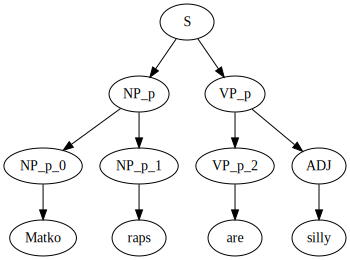

In [125]:
parse_result = trace[-1].derive_trees()[0]
parsing.render_tree(parse_result)

Collapse **CNF non-terminals**

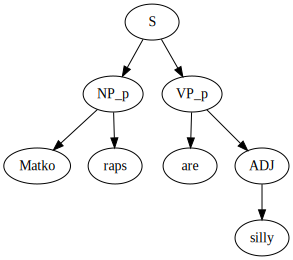

In [126]:
parsing.render_tree(parsing.filter_non_terminals(parse_result, cfg.n))

## Ambiguity 
For real world grammars many phrases have **several legal parse trees**

Consider the following grammar and sentence

In [127]:
amb_cfg = CFG.from_rules([
        ('S',    ['Subj','VP']),
        ('Subj', ['He']),
        ('Verb', ['shot']),
        ('VP',   ['Verb', 'Obj']),        ('VP', ['Verb', 'Obj', 'PP']),
        ('PP',   ['in','his','pyjamas']),
        ('Obj',  ['the','elephant']),     ('Obj', ['the','elephant','PP'])
    ])
amb_cnf_cfg = to_cnf(amb_cfg)
amb_sentence = ["He", "shot", "the", "elephant", "in", "his", "pyjamas"]

In [128]:
amb_cfg

S,Subj VP
Subj,He
Verb,shot
VP,Verb Obj
VP,Verb Obj PP
PP,in his pyjamas
Obj,the elephant
Obj,the elephant PP


In [129]:
amb_sentence

['He', 'shot', 'the', 'elephant', 'in', 'his', 'pyjamas']

In [130]:
amb_trace = cyk(amb_cnf_cfg, amb_sentence)
amb_parse_results = amb_trace[-1].derive_trees()
def ambiguous_tree(num):
    return parsing.render_tree(parsing.filter_non_terminals(amb_parse_results[num],amb_cfg.n)) # try results[1]

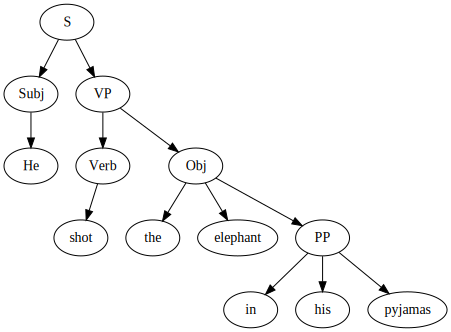

In [138]:
ambiguous_tree(0) # try tree 1 

**prepositional phrase attachment ambiguity**: "in his pyjamas" could be 

* in verb phrase (in pyjamas when shooting)
* in noun phrase (elephant in pyjamas)


Both readings are grammatical, but one is **more probable**

## Probabilistic Context Free Grammars
[Probabilistic Context Free Grammars](http://www.cs.columbia.edu/~mcollins/courses/nlp2011/notes/pcfgs.pdf) (PFCGs) are Context Free Grammars in which rules have probabilities 

* A Context Free Grammar \\(G(N,\Sigma,R,S)\\)
* A parameter \\(\param(\alpha \rightarrow \beta) \in \[0,1\]\\) for each rule  \\(\alpha \rightarrow \beta \in R\\) 
* For each left hand side \\(\alpha \in N\\) we require \\(\sum_\beta \param(\alpha \rightarrow \beta) = 1\\)

A PCFG defines probability for parse tree \\(\mathbf{t}\\) containing the rules \\(\alpha_1 \rightarrow \beta_1, \ldots, \alpha_n \rightarrow \beta_n\\):
$$
  \newcommand{parse}{\mathbf{t}}
  p_{\param}(\parse) = \prod_i^n \param(\alpha_i \rightarrow \beta_i) 
$$


Example PCFG:

In [132]:
pcfg = PCFG.from_rules([
        ('S',    1.0, ['Subj','VP']),
        ('Subj', 1.0, ['He']),
        ('Verb', 1.0, ['shot']),
        ('VP',   0.3, ['Verb', 'Obj']),        ('VP',  0.7, ['Verb', 'Obj', 'PP']),
        ('PP',   1.0, ['in','his','pyjamas']),
        ('Obj',  0.5, ['the','elephant']),     ('Obj', 0.5, ['the','elephant','PP'])
    ])
pcfg

S,1.0,Subj VP
Subj,1.0,He
Verb,1.0,shot
VP,0.3,Verb Obj
VP,0.7,Verb Obj PP
PP,1.0,in his pyjamas
Obj,0.5,the elephant
Obj,0.5,the elephant PP


## Parsing

For given sentence $\x$, let $\Ys(\x,G)$ be all trees $\mathbf{t}$ with $\x$ as terminals:

$$
\argmax_{\mathbf{t} \in \Ys(\x,G)} \prob_\params(\mathbf{t}) 
$$


## CYK for PCFGs

We can use a variant of the CYK algorithm to solve the prediction problem

In [133]:
cnf_pcfg

S,1.0,Subj VP
Subj,1.0,He
Verb,1.0,shot
VP,0.3,Verb Obj
VP,0.7,Verb VP_0
VP_0,1.0,Obj PP
PP_2,1.0,in
PP,1.0,PP_2 PP_1
PP_1_3,1.0,his
PP_1_4,1.0,pyjamas
PP_1,1.0,PP_1_3 PP_1_4


In [134]:
util.Carousel(pcyk_trace)

,0: He,1: shot,2: the,3: elephant,4: in,5: his,6: pyjamas
0: He,,,,,,,
1: shot,,,,,,,
2: the,,,,,,,
3: elephant,,,,,,,
4: in,,,,,,,
5: his,,,,,,,
6: pyjamas,,,,,,,
,0: He,1: shot,2: the,3: elephant,4: in,5: his,6: pyjamas
0: He,,,,,,,
1: shot,,,,,,,


Resolve parse by going backwards ... 

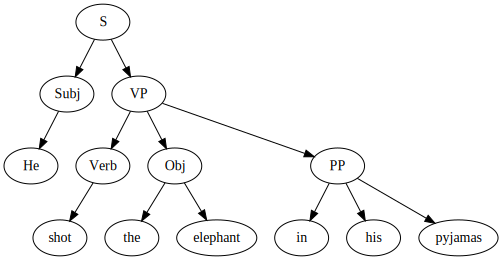

In [135]:
pcyk_trace = pcyk(cnf_pcfg, amb_sentence)
parsing.render_tree(parsing.filter_non_terminals(pcyk_trace[-1].derive_trees()[0],pcfg.cfg.n))

## Learning

Learning for PCFGs :

1. What should the rules in the grammar be?
2. What should the probabilities associated with these rules be?

Need corpus of parse trees $\train=(\parse_1, \ldots, \parse_n)$ 

* English: [Penn Treebank Project](https://www.cis.upenn.edu/~treebank/) parses for the 1989 Wall Street Journal (among other sources). 
* Other languages: e.g. [Chinese](https://catalog.ldc.upenn.edu/LDC2013T21)) 
* Other domains: e.g. [Biomedical Papers](www.nactem.ac.uk/aNT/genia.html))

Annotation expensive and need experts, major bottleneck in parsing research. 

To learn the parameters $\params$ of the model we can again use the maximum-likelihood criterium:

$$
\params^* = \argmax_\params \sum_{\parse \in \train} \log \prob_\params(\parse)
$$

Amounts to **counting**

$$
  \param(\alpha \rightarrow \beta) = \frac{\counts{\train}{\alpha \rightarrow \beta}}{\counts{\train}{\alpha}}
$$

Details omitted here, as you have seen this before

## Advanced: Parent Annotation

In practice 

* Let $X^Y$ be a non-terminal $X$ with parent $Y$
* **Grandparents** matter
    * $NP^{VP} \rightarrow NP \: PP$ vs 
    * $NP^{PP} \rightarrow NP \: PP$  
* Can be captured by labelling nodes in training trees with their parent
    * Same machinery

## Advanced: Head Driven PCFG

In practice 

* **VP NP** is not necessarily less or more likely than **VP NP PP**
* But **elephant** in **pyjamas** is very unlikely
* PCFGs must model relations between important words ("heads")
    * $PP^{NP(\text{elephant})} \rightarrow IN \: NP(\text{pyjamas})$ vs
    * $PP^{VP(\text{shot})} \rightarrow IN \: NP(\text{pyjamas})$
* Needs more complex model and search algorithms

## Background Material

* [Mike Collins' PCFG lecture](http://www.cs.columbia.edu/~mcollins/courses/nlp2011/notes/pcfgs.pdf)
* Jurafsky & Martin, Chapter 12, Statistical Parsing